# Importing Dependecies


In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from keras import regularizers, optimizers
import numpy as np
from keras.layers import Add
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten
from keras.utils import plot_model
from keras.preprocessing import image
import os
import re
from sklearn.model_selection import train_test_split
from keras.applications.imagenet_utils import preprocess_input
from sklearn.utils import shuffle
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [3]:
PATH = "/content/drive/MyDrive/Malaria_Cell_Dataset"
METRICS_PATH="/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/"
MODEL_NAME="ResNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/Malaria_Cell_Dataset


# Define Metrics

In [4]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [5]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [7]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [8]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Parasitized', 'Uninfected']


In [9]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        # print(img)
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #     x = x/255
        # print('Input image shape:', x.shape)
        img_data_list.append(x)

Loaded the images of dataset-Parasitized

Loaded the images of dataset-Uninfected



In [10]:
img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(27558, 1, 32, 32, 3)
(1, 27558, 32, 32, 3)
(27558, 32, 32, 3)


# Train & Test Data

In [11]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:13780] = 1
labels[13780:] = 0
names = ['Parasitized', 'Uninfected']

sample 27558


In [12]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [13]:
def initial_conv(Input, filters, stride=1, kernel_size=7):
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding="same")(Input)

    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    return x


def expand_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    Init = Input

    # First conv which is used to downsample the image
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])
    return x


def normal_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def expand_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    skip_conv = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])

    return x

def normal_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 Conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def build_basic_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                       first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_basic_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_basic_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_basic_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r4 - 1):
        x = normal_conv_basic_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Classifier Block
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def build_bottleneck_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                            first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_bottleneck_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_bottleneck_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_bottleneck_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv4
    for i in range(r4 - 1):
        x = normal_conv_bottleneck_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)

    # Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [14]:
model = build_bottleneck_resnet(32,32,2,3,4,6,3,2,True,7)
model.summary()
plot_model(model,"ResNet50.png",show_shapes=True)
model.compile(loss='binary_crossentropy',
        optimizer="Adam",
        metrics=['accuracy',f1,sensitivity,specificity])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [15]:
METRICS_PATH+MODEL_NAME+".csv"

'/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/ResNet.csv'

In [16]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")

model_chekpoint = ModelCheckpoint("ResNet50_F1score_DA_aug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

In [17]:

batch_size = 16
data_augmentation = True
epochs = 100

In [18]:
import time
start = time.time()

if data_augmentation:
    print("-------------Using Data augmentation------------")
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images

    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs, verbose=1, validation_data=(x_test, y_test),
                        callbacks=[lr_reducer,  csv_logger, model_chekpoint])

else:
    print("-----Not Using Data augmentation---------------")
    history = model.fit(x_train, y_train,
              batch_size=batch_size * 4,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,  csv_logger, model_chekpoint])


-------------Using Data augmentation------------
Epoch 1/100


<ipython-input-18-2c13fe4e579f>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


1377/1377 [==============================] - ETA: 0s - loss: 0.7254 - accuracy: 0.6474 - f1: 0.6474 - sensitivity: 0.6474 - specificity: 0.6474
Epoch 1: val_loss improved from inf to 1.21388, saving model to ResNet50_F1score_DA_aug.hdf5
1377/1377 [==============================] - 124s 55ms/step - loss: 0.7254 - accuracy: 0.6474 - f1: 0.6474 - sensitivity: 0.6474 - specificity: 0.6474 - val_loss: 1.2139 - val_accuracy: 0.5539 - val_f1: 0.5531 - val_sensitivity: 0.5531 - val_specificity: 0.5531 - lr: 0.0010
Epoch 2/100
1377/1377 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.6598 - f1: 0.6598 - sensitivity: 0.6598 - specificity: 0.6598
Epoch 2: val_loss did not improve from 1.21388
1377/1377 [==============================] - 76s 55ms/step - loss: 0.6833 - accuracy: 0.6598 - f1: 0.6598 - sensitivity: 0.6598 - specificity: 0.6598 - val_loss: 1.3865 - val_accuracy: 0.6116 - val_f1: 0.6111 - val_sensitivity: 0.6111 - val_specificity: 0.6111 - lr: 0.0010
Epoch 3/100

# Results

In [19]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 7534.214286804199
173/173 [==============================] - 2s 12ms/step - loss: 0.1090 - accuracy: 0.9617 - f1: 0.9619 - sensitivity: 0.9619 - specificity: 0.9619
dict_keys(['loss', 'accuracy', 'f1', 'sensitivity', 'specificity', 'val_loss', 'val_accuracy', 'val_f1', 'val_sensitivity', 'val_specificity', 'lr'])
dict_values([[0.7253891229629517, 0.6833365559577942, 0.659715473651886, 0.4893648326396942, 0.20984157919883728, 0.20319215953350067, 0.18558508157730103, 0.1810041218996048, 0.17159464955329895, 0.16893556714057922, 0.17329156398773193, 0.14545395970344543, 0.1367153525352478, 0.1352968066930771, 0.13170476257801056, 0.13205905258655548, 0.1305571347475052, 0.12289437651634216, 0.11856039613485336, 0.11796209961175919, 0.11599606275558472, 0.11704840511083603, 0.1175173968076706, 0.11375691741704941, 0.11084169149398804, 0.1117527186870575, 0.11126287281513214, 0.11150683462619781, 0.10813106596469879, 0.10860505700111389, 0.1081979945

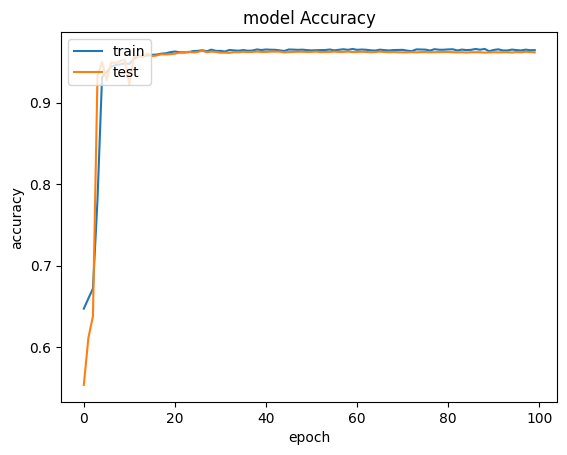

In [20]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


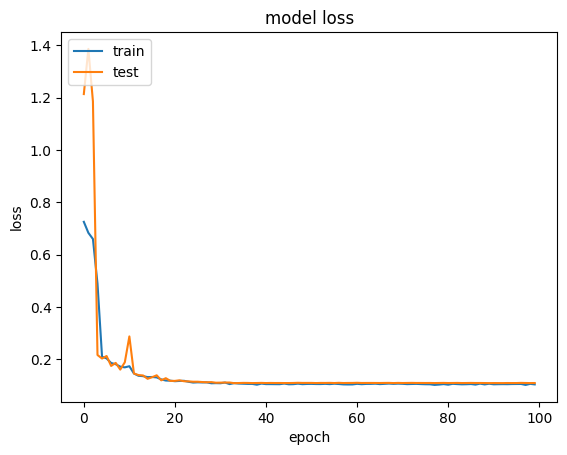

In [21]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


Without Augmentation

In [ ]:
PATH = "/content/drive/MyDrive/Malaria/Malaria_Cell_Dataset"
METRICS_PATH="/content/drive/MyDrive/Malaria/Malaria_Cell_Metrics/"
MODEL_NAME="ResNet_wag"
print("PWD", PATH)

PWD /content/drive/MyDrive/Malaria/Malaria_Cell_Dataset


In [ ]:
def initial_conv(Input, filters, stride=1, kernel_size=7):
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding="same")(Input)

    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    return x


def expand_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    Init = Input

    # First conv which is used to downsample the image
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])
    return x


def normal_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def expand_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    skip_conv = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])

    return x

def normal_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 Conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def build_basic_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                       first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_basic_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_basic_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_basic_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r4 - 1):
        x = normal_conv_basic_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Classifier Block
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def build_bottleneck_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                            first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_bottleneck_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_bottleneck_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_bottleneck_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv4
    for i in range(r4 - 1):
        x = normal_conv_bottleneck_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)

    # Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [ ]:
model = build_bottleneck_resnet(32,32,2,3,4,6,3,2,True,7)
model.summary()
plot_model(model,"ResNet50_wag.png",show_shapes=True)
model.compile(loss='binary_crossentropy',
        optimizer="Adam",
        metrics=['accuracy',f1,sensitivity,specificity])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("ResNet50_F1score_DA_aug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:

batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start = time.time()

if data_augmentation:
    print("-------------Using Data augmentation------------")
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images

    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs, verbose=1, validation_data=(x_test, y_test),
                        callbacks=[lr_reducer,  csv_logger, model_chekpoint])

else:
    print("-----Not Using Data augmentation---------------")
    history = model.fit(x_train, y_train,
              batch_size=batch_size * 4,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,  csv_logger, model_chekpoint])


-----Not Using Data augmentation---------------
Epoch 1/100
345/345 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6984 - f1: 0.6985 - sensitivity: 0.6985 - specificity: 0.6985
Epoch 1: val_loss improved from inf to 0.72020, saving model to ResNet50_F1score_DA_aug.hdf5
345/345 [==============================] - 76s 60ms/step - loss: 0.6674 - accuracy: 0.6984 - f1: 0.6985 - sensitivity: 0.6985 - specificity: 0.6985 - val_loss: 0.7202 - val_accuracy: 0.6606 - val_f1: 0.6589 - val_sensitivity: 0.6589 - val_specificity: 0.6589 - lr: 0.0010
Epoch 2/100
345/345 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8216 - f1: 0.8218 - sensitivity: 0.8218 - specificity: 0.8218
Epoch 2: val_loss improved from 0.72020 to 0.45404, saving model to ResNet50_F1score_DA_aug.hdf5
345/345 [==============================] - 18s 53ms/step - loss: 0.4132 - accuracy: 0.8216 - f1: 0.8218 - sensitivity: 0.8218 - specificity: 0.8218 - val_loss: 0.4540 - val_accuracy:

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 2550.7592375278473
173/173 [==============================] - 3s 13ms/step - loss: 0.5364 - accuracy: 0.9329 - f1: 0.9332 - sensitivity: 0.9332 - specificity: 0.9332
dict_keys(['loss', 'accuracy', 'f1', 'sensitivity', 'specificity', 'val_loss', 'val_accuracy', 'val_f1', 'val_sensitivity', 'val_specificity', 'lr'])
dict_values([[0.6673594117164612, 0.4131864905357361, 0.2727060616016388, 0.19491863250732422, 0.12028965353965759, 0.09350138902664185, 0.07799872010946274, 0.033424459397792816, 0.012670572847127914, 0.005522019229829311, 0.0024824868887662888, 0.0010692080250009894, 0.0010071537690237164, 0.0008211518288590014, 0.0010722022270783782, 0.0005889998865313828, 0.0005887591396458447, 0.001066755736246705, 0.0007329543586820364, 0.0007940191426314414, 0.0005825813859701157, 0.0005495977238751948, 0.0004874409642070532, 0.0004937995108775795, 0.0005500852130353451, 0.0005419188528321683, 0.0010679648257791996, 0.0004008512187283486, 0.00039

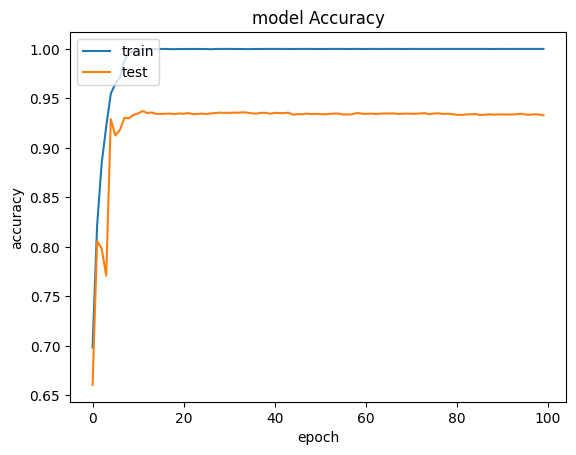

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


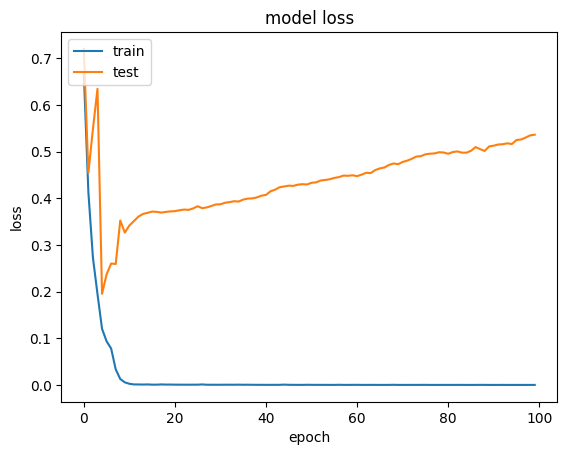

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
